In [1]:
#Import necessary Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import folium
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans



In [2]:
# Load the dataset into a pandas DataFrame
weather_data = pd.read_csv('C:\\Weather_Analysis_Dataset\\WeatherEvents_Jan2016-Dec2022.csv')

# Display the first few rows of the dataset to verify its structure
weather_data.head(6)

EventId  Type Severity       StartTime(UTC)         EndTime(UTC)  \
0     W-1  Snow    Light  2016-01-06 23:14:00  2016-01-07 00:34:00   
1     W-2  Snow    Light  2016-01-07 04:14:00  2016-01-07 04:54:00   
2     W-3  Snow    Light  2016-01-07 05:54:00  2016-01-07 15:34:00   
3     W-4  Snow    Light  2016-01-08 05:34:00  2016-01-08 05:54:00   
4     W-5  Snow    Light  2016-01-08 13:54:00  2016-01-08 15:54:00   
5     W-6  Snow    Light  2016-01-08 16:14:00  2016-01-08 17:34:00   

   Precipitation(in)     TimeZone AirportCode  LocationLat  LocationLng  \
0               0.00  US/Mountain        K04V      38.0972    -106.1689   
1               0.00  US/Mountain        K04V      38.0972    -106.1689   
2               0.03  US/Mountain        K04V      38.0972    -106.1689   
3               0.00  US/Mountain        K04V      38.0972    -106.1689   
4               0.00  US/Mountain        K04V      38.0972    -106.1689   
5               0.00  US/Mountain        K04V      38.0972    -106.1689   

       City    County State  ZipCode  
0  Saguache  Saguache    CO  81149.0  
1  Saguache  Saguache    CO  81149.0  
2  Saguache  Saguache    CO  81149.0  
3  Saguache  Saguache    CO  81149.0  
4  Saguache  Saguache    CO  81149.0  
5  Saguache  Saguache    CO  81149.0

In [3]:
# Check for Null Values
print(weather_data.isna().sum())

EventId                  0
Type                     0
Severity                 0
StartTime(UTC)           0
EndTime(UTC)             0
Precipitation(in)        0
TimeZone                 0
AirportCode              0
LocationLat              0
LocationLng              0
City                 16912
County                   0
State                    0
ZipCode              69199
dtype: int64


In [4]:
# Remove/Drop the Null Values
weather_data = weather_data.dropna()

# Print the shape of the cleaned DataFrame to see how many rows remain
print("Shape of the cleaned DataFrame:", weather_data.shape)


Shape of the cleaned DataFrame: (8557982, 14)


In [5]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8557982 entries, 0 to 8627180
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   EventId            object 
 1   Type               object 
 2   Severity           object 
 3   StartTime(UTC)     object 
 4   EndTime(UTC)       object 
 5   Precipitation(in)  float64
 6   TimeZone           object 
 7   AirportCode        object 
 8   LocationLat        float64
 9   LocationLng        float64
 10  City               object 
 11  County             object 
 12  State              object 
 13  ZipCode            float64
dtypes: float64(4), object(10)
memory usage: 979.4+ MB


In [6]:
weather_data.describe()

Precipitation(in)   LocationLat   LocationLng       ZipCode
count       8.557982e+06  8.557982e+06  8.557982e+06  8.557982e+06
mean        9.326591e-02  3.878326e+01 -9.183536e+01  5.241150e+04
std         8.903775e-01  5.453916e+00  1.346044e+01  2.573249e+04
min         0.000000e+00  2.455710e+01 -1.245550e+02  1.022000e+03
25%         0.000000e+00  3.460420e+01 -9.768780e+01  3.121600e+04
50%         0.000000e+00  3.933250e+01 -8.971000e+01  5.391300e+04
75%         5.000000e-02  4.301940e+01 -8.189210e+01  7.350300e+04
max         1.104130e+03  4.894020e+01 -6.779280e+01  9.936200e+04

In [7]:
weather_data.Type.value_counts()

Type
Rain             4974556
Fog              1992230
Snow             1143419
Cold              230205
Precipitation     156549
Storm              58114
Hail                2909
Name: count, dtype: int64

In [7]:
# Feature Transformation and Feature Engineering

# Create a New variable Duration to calculate the duration of every weather event using the start and end time of the event

datetimeFormat = '%Y-%m-%d %H:%M:%S'
weather_data['EndTime(UTC)']=pd.to_datetime(weather_data['EndTime(UTC)'], format=datetimeFormat)
weather_data['StartTime(UTC)']=pd.to_datetime(weather_data['StartTime(UTC)'], format=datetimeFormat)
weather_data['Duration']=weather_data['EndTime(UTC)']-weather_data['StartTime(UTC)']
weather_data['Duration'] = weather_data['Duration'].dt.total_seconds()
weather_data['Duration'] = weather_data['Duration'] / (60*60) # Converting to hours
weather_data = weather_data[(weather_data['Duration']< 30*24) & (weather_data['Duration'] > 0)] # More than 30 days or less than 0 hours discard.
weather_data.head()



EventId  Type Severity      StartTime(UTC)        EndTime(UTC)  \
0     W-1  Snow    Light 2016-01-06 23:14:00 2016-01-07 00:34:00   
1     W-2  Snow    Light 2016-01-07 04:14:00 2016-01-07 04:54:00   
2     W-3  Snow    Light 2016-01-07 05:54:00 2016-01-07 15:34:00   
3     W-4  Snow    Light 2016-01-08 05:34:00 2016-01-08 05:54:00   
4     W-5  Snow    Light 2016-01-08 13:54:00 2016-01-08 15:54:00   

   Precipitation(in)     TimeZone AirportCode  LocationLat  LocationLng  \
0               0.00  US/Mountain        K04V      38.0972    -106.1689   
1               0.00  US/Mountain        K04V      38.0972    -106.1689   
2               0.03  US/Mountain        K04V      38.0972    -106.1689   
3               0.00  US/Mountain        K04V      38.0972    -106.1689   
4               0.00  US/Mountain        K04V      38.0972    -106.1689   

       City    County State  ZipCode  Duration  
0  Saguache  Saguache    CO  81149.0  1.333333  
1  Saguache  Saguache    CO  81149.0  0.666667  
2  Saguache  Saguache    CO  81149.0  9.666667  
3  Saguache  Saguache    CO  81149.0  0.333333  
4  Saguache  Saguache    CO  81149.0  2.000000

In [8]:

# Extract additional features from the datetime columns
weather_data['Start_year'] = weather_data['StartTime(UTC)'].dt.year
weather_data['Start_month'] = weather_data['StartTime(UTC)'].dt.month
weather_data['Start_week'] = weather_data['StartTime(UTC)'].dt.isocalendar().week
weather_data['Start_weekday'] = weather_data['StartTime(UTC)'].dt.weekday
weather_data['Start_day'] = weather_data['StartTime(UTC)'].dt.day

weather_data['End_year'] = weather_data['EndTime(UTC)'].dt.year
weather_data['End_month'] = weather_data['EndTime(UTC)'].dt.month
weather_data['End_week'] = weather_data['EndTime(UTC)'].dt.isocalendar().week
weather_data['End_weekday'] = weather_data['EndTime(UTC)'].dt.weekday
weather_data['End_day'] = weather_data['EndTime(UTC)'].dt.day


In [9]:
#Scaling the variable "Duration"

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the 'Duration' column
weather_data['Duration'] = scaler.fit_transform(weather_data[['Duration']])

# Display the first few rows of the DataFrame with the normalized duration
print(weather_data.head())


  EventId  Type Severity      StartTime(UTC)        EndTime(UTC)  \
0     W-1  Snow    Light 2016-01-06 23:14:00 2016-01-07 00:34:00   
1     W-2  Snow    Light 2016-01-07 04:14:00 2016-01-07 04:54:00   
2     W-3  Snow    Light 2016-01-07 05:54:00 2016-01-07 15:34:00   
3     W-4  Snow    Light 2016-01-08 05:34:00 2016-01-08 05:54:00   
4     W-5  Snow    Light 2016-01-08 13:54:00 2016-01-08 15:54:00   

   Precipitation(in)     TimeZone AirportCode  LocationLat  LocationLng  ...  \
0               0.00  US/Mountain        K04V      38.0972    -106.1689  ...   
1               0.00  US/Mountain        K04V      38.0972    -106.1689  ...   
2               0.03  US/Mountain        K04V      38.0972    -106.1689  ...   
3               0.00  US/Mountain        K04V      38.0972    -106.1689  ...   
4               0.00  US/Mountain        K04V      38.0972    -106.1689  ...   

  Start_year Start_month Start_week  Start_weekday  Start_day  End_year  \
0       2016           1          1

In [10]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8557599 entries, 0 to 8627180
Data columns (total 25 columns):
 #   Column             Dtype         
---  ------             -----         
 0   EventId            object        
 1   Type               object        
 2   Severity           object        
 3   StartTime(UTC)     datetime64[ns]
 4   EndTime(UTC)       datetime64[ns]
 5   Precipitation(in)  float64       
 6   TimeZone           object        
 7   AirportCode        object        
 8   LocationLat        float64       
 9   LocationLng        float64       
 10  City               object        
 11  County             object        
 12  State              object        
 13  ZipCode            float64       
 14  Duration           float64       
 15  Start_year         int32         
 16  Start_month        int32         
 17  Start_week         UInt32        
 18  Start_weekday      int32         
 19  Start_day          int32         
 20  End_year           int32     

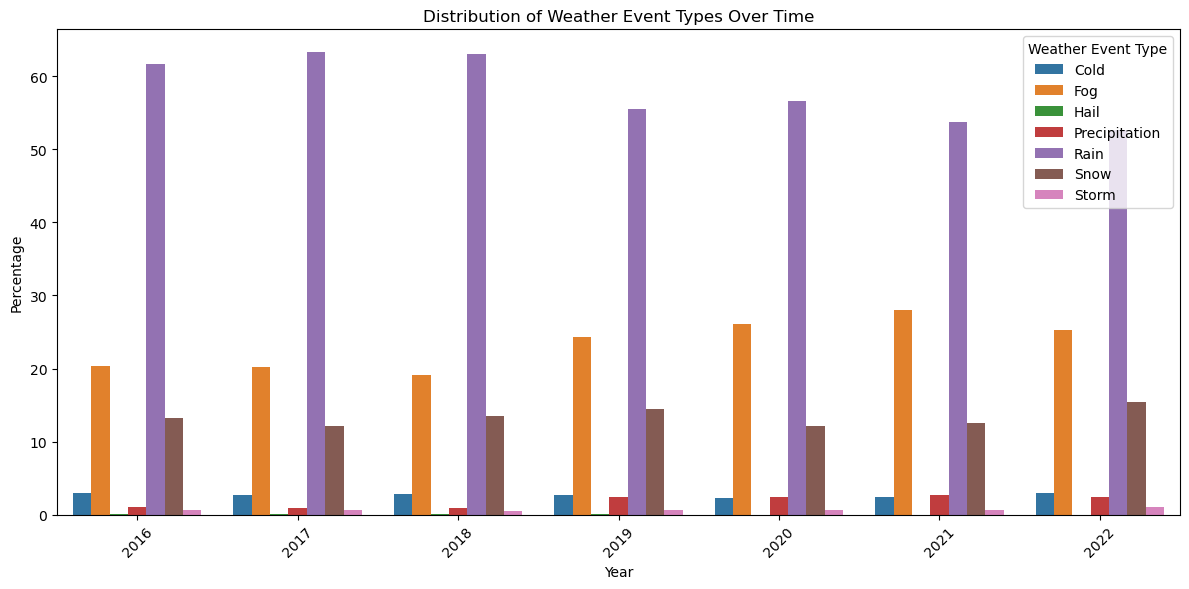

In [11]:
#Distribution of Weather Event Types Over Time

# Calculate the percentage of each weather event type for each year
event_type_percentage = weather_data.groupby([weather_data['StartTime(UTC)'].dt.year, 'Type']).size() / weather_data.groupby(weather_data['StartTime(UTC)'].dt.year).size() * 100
event_type_percentage = event_type_percentage.reset_index(name='Percentage')

# Plotting the distribution of weather event types over time with percentages
plt.figure(figsize=(12, 6))
sns.barplot(data=event_type_percentage, x='StartTime(UTC)', y='Percentage', hue='Type', dodge=True)
plt.title('Distribution of Weather Event Types Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='Weather Event Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Weather_image.png')
plt.show()


In [12]:
# Define a function to plot distribution based on severity
def plot_distribution_by_severity(data, event_type):
    plt.figure(figsize=(10, 6))
    for severity in data['Severity'].unique():
        severity_data = data[data['Severity'] == severity]
        plt.scatter(severity_data['LocationLng'], severity_data['LocationLat'], label=severity, alpha=0.5)
    plt.title(f'Distribution of {event_type} Across the USA by Severity')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

# Separate data for each weather event type
rain_data = weather_data[weather_data['Type'] == 'Rain']
fog_data = weather_data[weather_data['Type'] == 'Fog']
snow_data = weather_data[weather_data['Type'] == 'Snow']
cold_data = weather_data[weather_data['Type'] == 'Cold']
precipitation_data = weather_data[weather_data['Type'] == 'Precipitation']
storm_data = weather_data[weather_data['Type'] == 'Storm']
hail_data = weather_data[weather_data['Type'] == 'Hail']


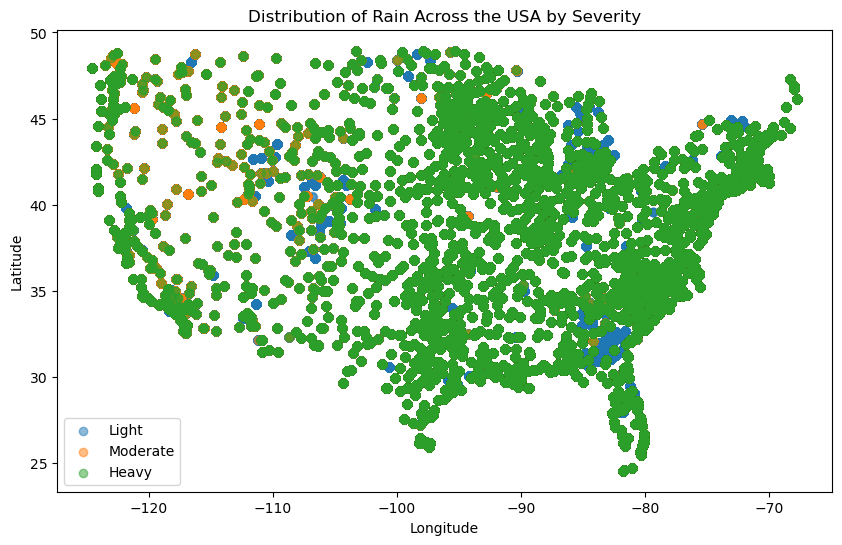

In [13]:
# Plot distributions based on severity of Rain
plot_distribution_by_severity(rain_data, 'Rain')

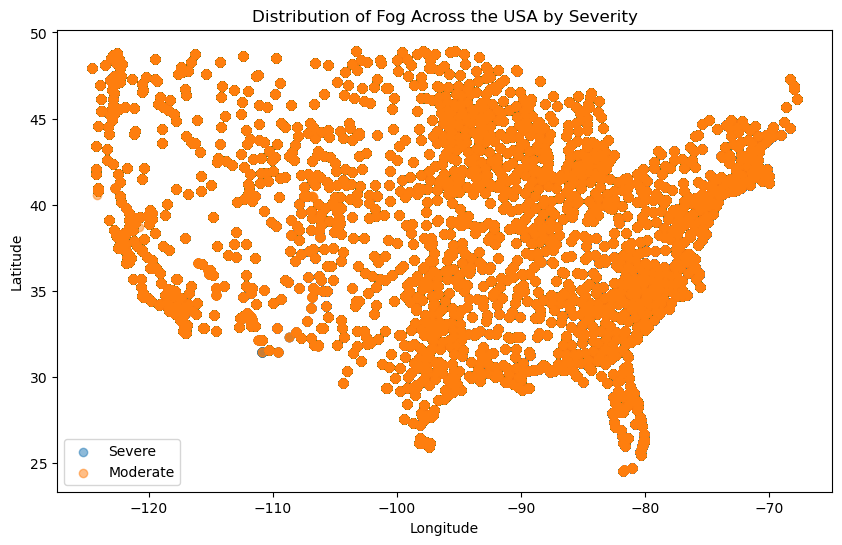

In [14]:
# Plot distributions based on severity of Fog
plot_distribution_by_severity(fog_data, 'Fog')

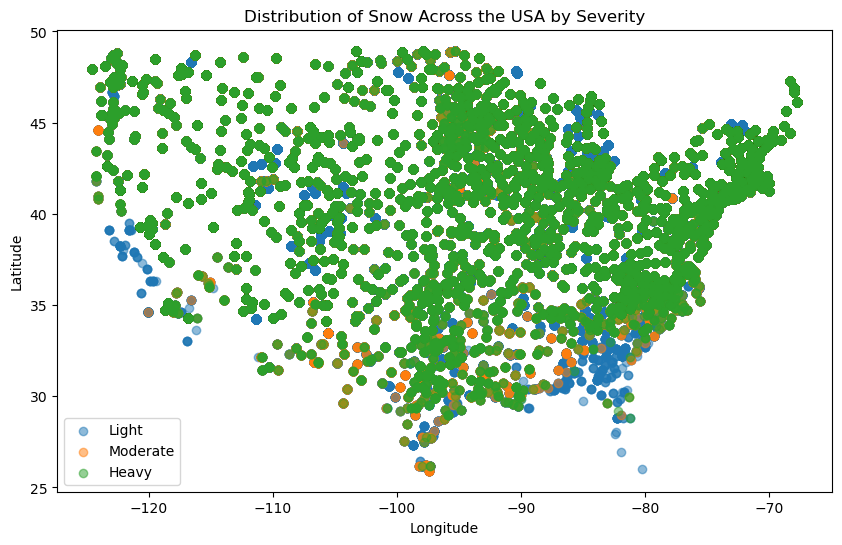

In [15]:
# Plot distributions based on severity of Snow
plot_distribution_by_severity(snow_data, 'Snow')

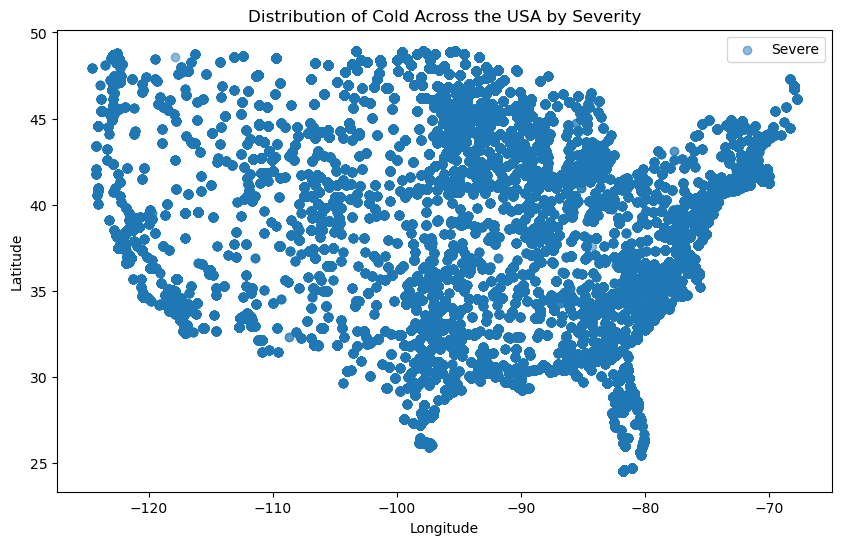

In [16]:
# Plot distributions based on severity of Cold
plot_distribution_by_severity(cold_data, 'Cold')

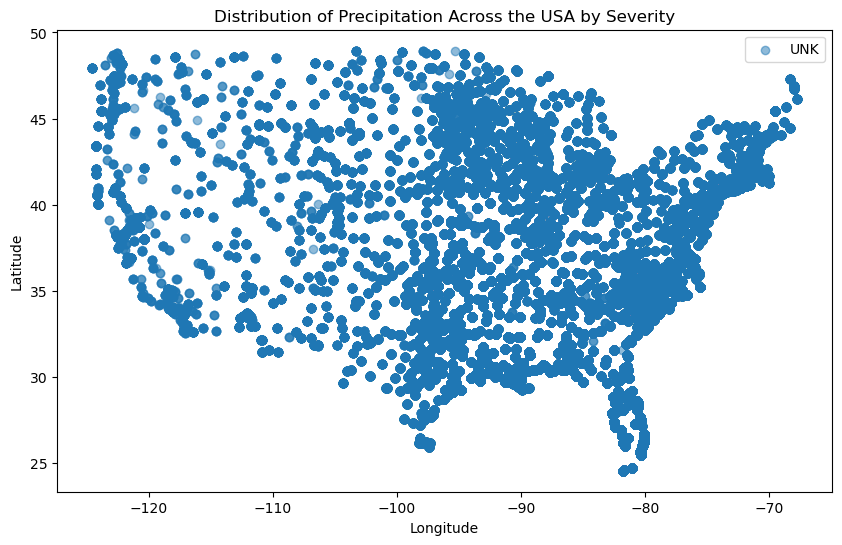

In [17]:
# Plot distributions based on severity of Precipitation
plot_distribution_by_severity(precipitation_data, 'Precipitation')

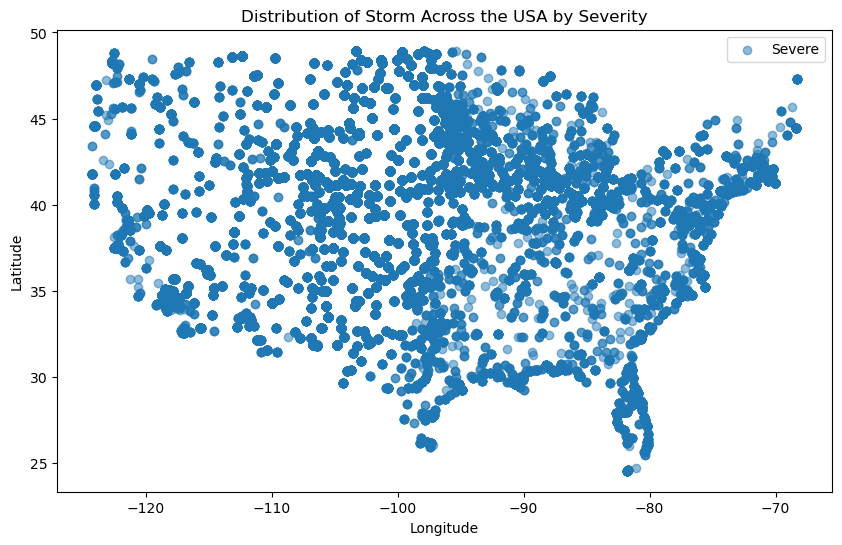

In [18]:
# Plot distributions based on severity of Storm
plot_distribution_by_severity(storm_data, 'Storm')

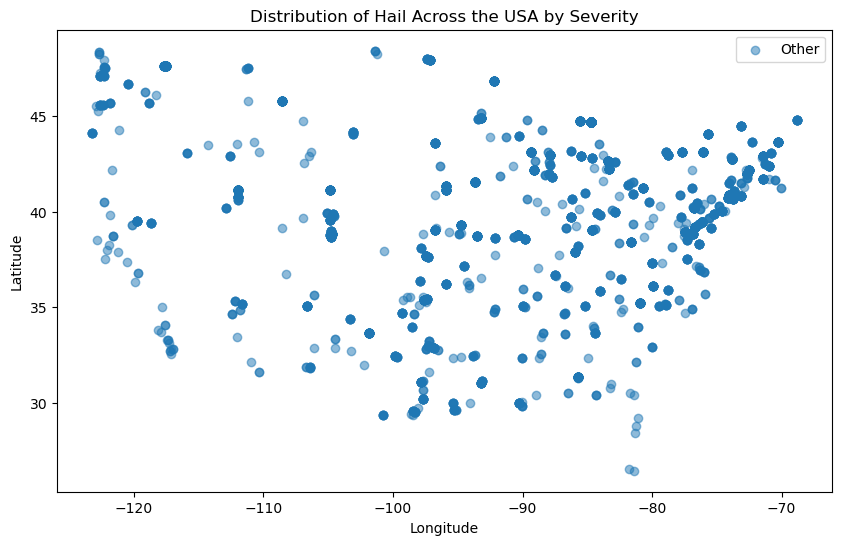

In [19]:
# Plot distributions based on severity of Hail
plot_distribution_by_severity(hail_data, 'Hail')

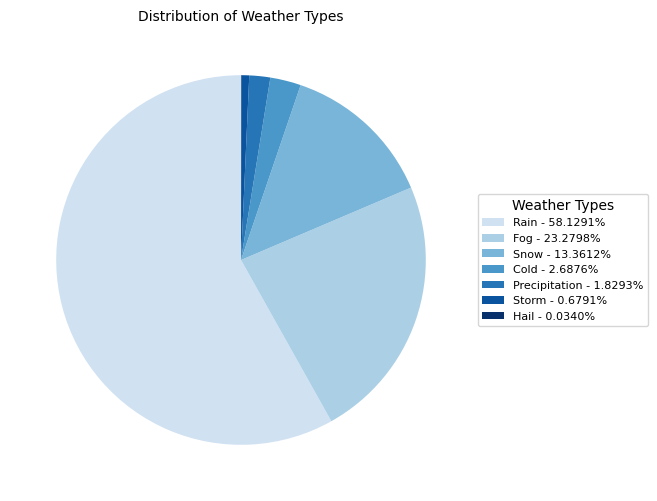

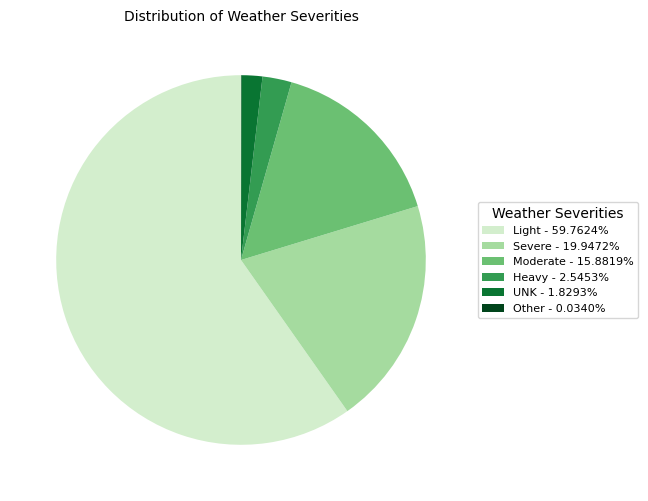

In [20]:
#Weather type and severity distribution in the dataset 

# Custom colormap for shades of blue
colors = plt.cm.Blues(np.linspace(0.2, 1, len(weather_data['Type'].unique())))

# Plot for 'type of weather' column
plt.figure(figsize=(6, 6))
type_counts = weather_data['Type'].value_counts()
patches, _ = plt.pie(type_counts, startangle=90, colors=colors)

# Create custom legend as a table
legend_labels = [f'{l} - {s:.4f}%' for l, s in zip(type_counts.index, 100 * type_counts / len(weather_data))]
plt.legend(patches, legend_labels, 
           loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8, title='Weather Types')

plt.title('Distribution of Weather Types', fontsize=10)
plt.gca().set_aspect('equal')  # Ensure pie chart is circular

plt.show()


# Custom colormap for shades of blue
colors_2 = plt.cm.Greens(np.linspace(0.2, 1, len(weather_data['Severity'].unique())))

# Plot for 'severity' column
plt.figure(figsize=(6, 6))
severity_counts = weather_data['Severity'].value_counts()
patches, _ = plt.pie(severity_counts, startangle=90, colors=colors_2)

# Create custom legend as a table
legend_labels = [f'{l} - {s:.4f}%' for l, s in zip(severity_counts.index, 100.0 * severity_counts / len(weather_data))]
plt.legend(patches, legend_labels, 
           loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8, title='Weather Severities')

plt.title('Distribution of Weather Severities', fontsize=10)
plt.gca().set_aspect('equal')  # Ensure pie chart is circular

plt.show()


In [21]:
# Preparing the data for K-Means Clustering 

weather_data_grouped = weather_data.groupby(['AirportCode','City','State', 'LocationLat', 'LocationLng','Type']).agg({'Duration':['sum']}).reset_index()
weather_data_grouped.columns = pd.MultiIndex.from_tuples((
    ("AirportCode", " "),("City", " "),("State", " "),("LocationLat", " "),
    ("LocationLng", " "),("Type", " "),("Duration", " ")))
weather_data_grouped.columns = weather_data_grouped.columns.get_level_values(0)
weather_data_grouped['Duration'] = weather_data_grouped['Duration'] / (24*6*3.65) # Yearly Percentage
weather_data_grouped = weather_data_grouped.sort_values(by='Duration')
weather_data_grouped.tail(3)


AirportCode            City State  LocationLat  LocationLng  Type  \
11257        KUIL           Forks    WA      47.9375    -124.5550  Rain   
10688        KSXT      Wolf Creek    OR      42.6000    -123.3656   Fog   
8110         KNRS  Imperial Beach    CA      32.5630    -117.1109  Cold   

       Duration  
11257  0.028387  
10688  0.030099  
8110   0.033349

In [22]:
weather_data_flat = weather_data_grouped.pivot_table(index='AirportCode', columns='Type', values=['Duration']).reset_index().fillna(0)
weather_data_flat.columns = pd.MultiIndex.from_tuples(((' ', 'AirportCode'),(' ', 'Cold'),(' ', 'Fog'),
            (' ',  'Hail'),(' ', 'Precipitation'),(' ', 'Rain'),(' ', 'Snow'),(' ', 'Storm')))
weather_data_flat.columns = weather_data_flat.columns.get_level_values(1)
unique_key = weather_data_grouped[['AirportCode', 'City', 'State', 'LocationLat', 'LocationLng']].sort_values(by='AirportCode').drop_duplicates()
weather = pd.merge(weather_data_flat, unique_key, how='inner', on='AirportCode')
weather.tail(3)


AirportCode      Cold       Fog      Hail  Precipitation      Rain  \
2051        KYNG  0.000018  0.004126  0.000014       0.000147  0.015883   
2052        KZPH  0.001115  0.002765  0.000000       0.000079  0.007184   
2053        KZZV  0.000228  0.003248  0.000000       0.000142  0.009986   

          Snow     Storm         City State  LocationLat  LocationLng  
2051  0.013148  0.000005       Vienna    OH      41.2544     -80.6739  
2052  0.000000  0.000003  Zephyrhills    FL      28.2281     -82.1559  
2053  0.003088  0.000000   Zanesville    OH      39.9444     -81.8921

In [23]:
X = weather_data_flat.drop(['AirportCode','Cold', 'Hail'], axis=1)
X.tail(3)

Fog  Precipitation      Rain      Snow     Storm
2051  0.004126       0.000147  0.015883  0.013148  0.000005
2052  0.002765       0.000079  0.007184  0.000000  0.000003
2053  0.003248       0.000142  0.009986  0.003088  0.000000

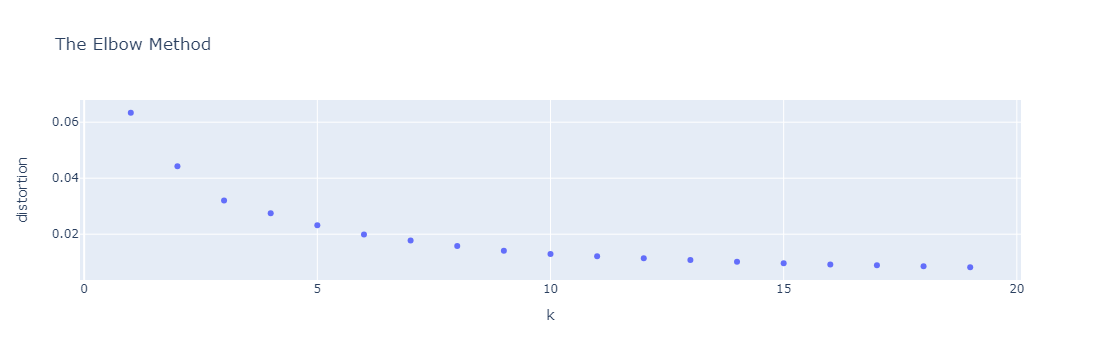

In [24]:
# Elbow Method to Find the Optimal K-Value

distortions = []

K = range(1,20)
for k in K:
    kmean = KMeans(n_clusters=k, random_state=0, n_init = 50, max_iter = 500)
    kmean.fit(X)
    distortions.append(kmean.inertia_)
    
fig_kmean = px.scatter(x=K, y=distortions, title='The Elbow Method')
fig_kmean.update_xaxes(title_text='k')
fig_kmean.update_yaxes(title_text='distortion')
fig_kmean.show()

In [25]:
# Applying K-Means with K=4

kmeans = KMeans(n_clusters=4, random_state=0).fit(X) ## K=4

weather_data_flat['Cluster'] = (kmeans.labels_).astype(str)
weather_data_cluster = pd.merge(weather_data_flat[['AirportCode','Cluster']], weather.drop(['Cold','Hail'], axis=1), 
                      how='inner', on='AirportCode')
weather_data_cluster.tail(3)

C:\Users\chand\anaconda3\New folder\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



AirportCode Cluster       Fog  Precipitation      Rain      Snow  \
2051        KYNG       3  0.004126       0.000147  0.015883  0.013148   
2052        KZPH       1  0.002765       0.000079  0.007184  0.000000   
2053        KZZV       1  0.003248       0.000142  0.009986  0.003088   

         Storm         City State  LocationLat  LocationLng  
2051  0.000005       Vienna    OH      41.2544     -80.6739  
2052  0.000003  Zephyrhills    FL      28.2281     -82.1559  
2053  0.000000   Zanesville    OH      39.9444     -81.8921

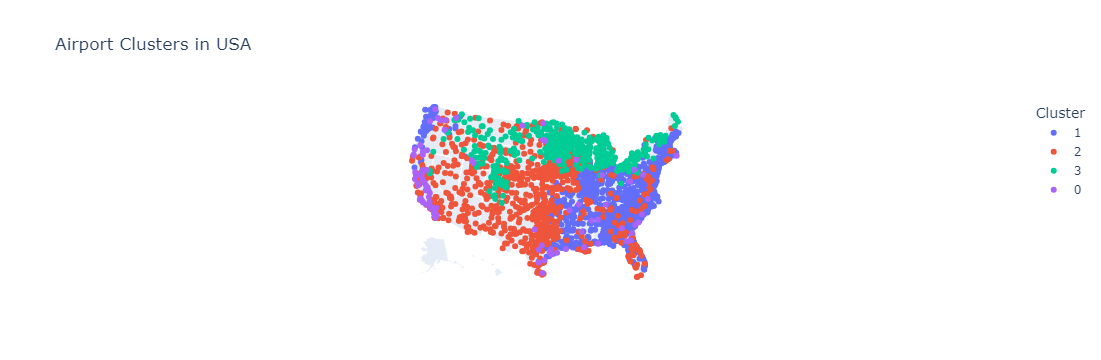

In [26]:

# Plotting the clusters on a map of the USA
fig = px.scatter_geo(weather_data_cluster, 
                     lat='LocationLat', 
                     lon='LocationLng', 
                     color='Cluster',
                     hover_name='AirportCode',
                     size_max=10,
                     title='Airport Clusters in USA',
                     scope='usa')  # Set scope to 'usa' to restrict the map to the USA
fig.show()


In [27]:

# Calculate the silhouette score
silhouette_avg = silhouette_score(X, kmeans.labels_)
print("The average silhouette_score is :", silhouette_avg)


The average silhouette_score is : 0.3624545041000471


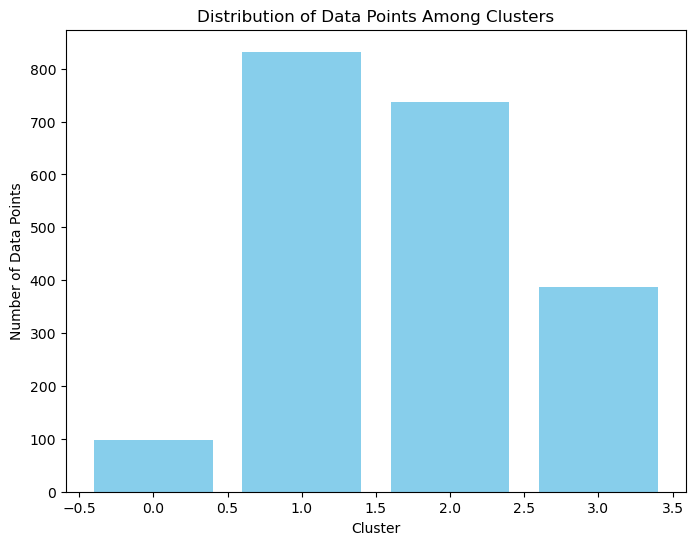

In [28]:
#Distribution of Data Points Among Clusters

# Count the number of data points in each cluster
cluster_counts = weather_data_cluster['Cluster'].value_counts()

# Plotting the distribution of data points among clusters
plt.figure(figsize=(8, 6))
plt.bar(cluster_counts.index.astype(int), cluster_counts.values, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Distribution of Data Points Among Clusters')
plt.show()


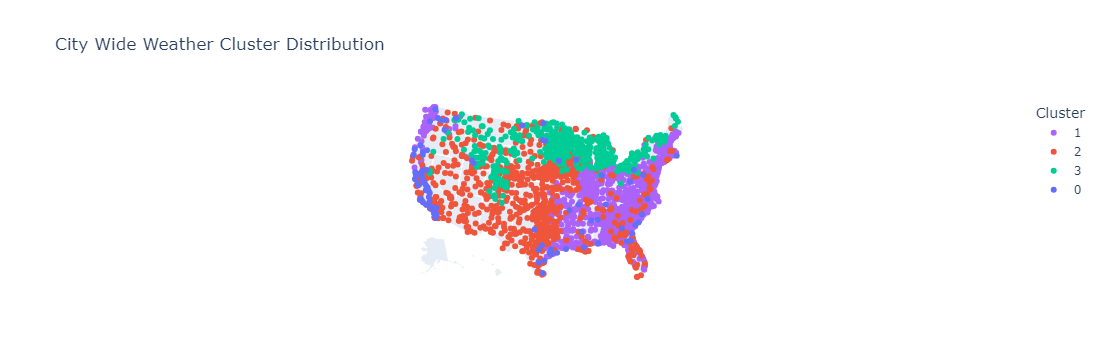

In [29]:
#City Wide Weather Cluster Distribution
# Plotting the cluster distribution across cities on a map of the USA
fig_cluster = px.scatter_geo(weather_data_cluster, 
                             lat='LocationLat', 
                             lon='LocationLng',
                             hover_name=weather_data_cluster['City'] + ', ' + weather_data_cluster['State'],
                             scope="usa",
                             color='Cluster',
                             color_discrete_sequence=['#AB63FA', '#EF553B', '#00CC96', '#636EFA'],
                             title='City Wide Weather Cluster Distribution')
fig_cluster.show()


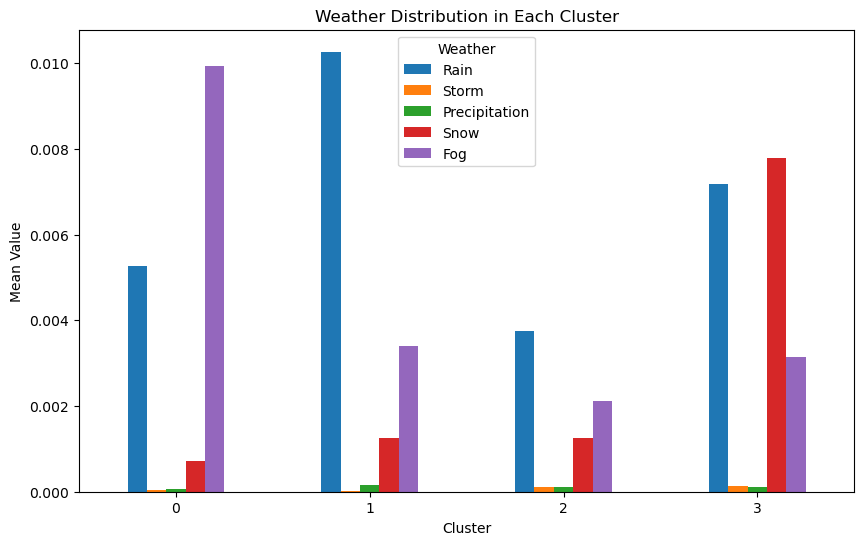

In [30]:
# Weather Distribution in Each Cluster

# Filter the DataFrame to include only the relevant columns
weather_subset = weather_data_cluster[['Cluster', 'Rain', 'Storm', 'Precipitation', 'Snow', 'Fog']]

# Group data by cluster and calculate the mean of weather events
cluster_weather_mean = weather_subset.groupby('Cluster').mean()

# Plotting the grouped bar plot
cluster_weather_mean.plot(kind='bar', figsize=(10, 6))
plt.title('Weather Distribution in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Value')
plt.xticks(rotation=0)
plt.legend(title='Weather')
plt.show()


In [31]:
# Encoding the Categorical variables

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate over each column in the DataFrame
for column in weather_data.columns:
    # Check if the column dtype is object (categorical)
    if weather_data[column].dtype == 'object':
        # Apply LabelEncoder to transform the categorical column
        weather_data[column] = label_encoder.fit_transform(weather_data[column])

# Display the modified DataFrame
print(weather_data.head())

   EventId  Type  Severity      StartTime(UTC)        EndTime(UTC)  \
0        0     5         1 2016-01-06 23:14:00 2016-01-07 00:34:00   
1  1048123     5         1 2016-01-07 04:14:00 2016-01-07 04:54:00   
2  2080867     5         1 2016-01-07 05:54:00 2016-01-07 15:34:00   
3  3126369     5         1 2016-01-08 05:34:00 2016-01-08 05:54:00   
4  4177958     5         1 2016-01-08 13:54:00 2016-01-08 15:54:00   

   Precipitation(in)  TimeZone  AirportCode  LocationLat  LocationLng  ...  \
0               0.00         2            1      38.0972    -106.1689  ...   
1               0.00         2            1      38.0972    -106.1689  ...   
2               0.03         2            1      38.0972    -106.1689  ...   
3               0.00         2            1      38.0972    -106.1689  ...   
4               0.00         2            1      38.0972    -106.1689  ...   

   Start_year  Start_month  Start_week  Start_weekday  Start_day  End_year  \
0        2016            1      

In [32]:
# Drop StartTime(UTC) and EndTime(UTC) columns
weather_data = weather_data.drop(columns=['StartTime(UTC)', 'EndTime(UTC)'])
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8557599 entries, 0 to 8627180
Data columns (total 23 columns):
 #   Column             Dtype  
---  ------             -----  
 0   EventId            int32  
 1   Type               int32  
 2   Severity           int32  
 3   Precipitation(in)  float64
 4   TimeZone           int32  
 5   AirportCode        int32  
 6   LocationLat        float64
 7   LocationLng        float64
 8   City               int32  
 9   County             int32  
 10  State              int32  
 11  ZipCode            float64
 12  Duration           float64
 13  Start_year         int32  
 14  Start_month        int32  
 15  Start_week         UInt32 
 16  Start_weekday      int32  
 17  Start_day          int32  
 18  End_year           int32  
 19  End_month          int32  
 20  End_week           UInt32 
 21  End_weekday        int32  
 22  End_day            int32  
dtypes: UInt32(2), float64(5), int32(16)
memory usage: 995.7 MB


In [33]:
#Applying Machine Learning Models

# Split the data into features (X) and target (y)
X = weather_data.drop(columns=['Type'])
y = weather_data['Type']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


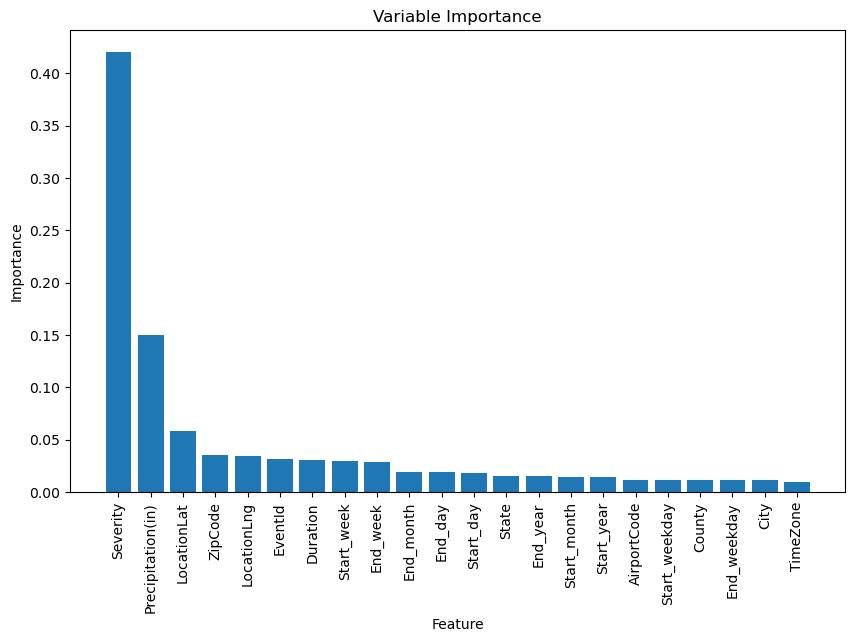

In [34]:
## Random Forest Classifier

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=25, random_state=42)

# Fit the Random Forest model on the training data
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Get the names of features
feature_names = X.columns

# Sort feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]

# Plot variable importance
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[sorted_indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Variable Importance')
plt.show()

In [35]:
# Make predictions on the test set
predictions = rf_classifier.predict(X_test)

print("Random Forest model Performance:")

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Compute precision
precision = precision_score(y_test, predictions, average='weighted')

# Compute recall
recall = recall_score(y_test, predictions, average='weighted')

# Compute F1 score
f1 = f1_score(y_test, predictions, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Random Forest model Performance:
Accuracy: 0.9601599747592783
Precision: 0.9595672013542043
Recall: 0.9601599747592783
F1 Score: 0.9594587700105601


In [36]:
### XGBoost classifier

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=25, max_depth=3, learning_rate=0.1)

# Fit the model on the training data
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("XGBoost Model Performance:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

C:\Users\chand\anaconda3\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



XGBoost Model Performance:
Accuracy: 0.8705092549312892
Precision: 0.6509052461003683
Recall: 0.6216080969366583
F1 Score: 0.6234484461232501


In [37]:
#LightGBM classifier

# Initialize the LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(n_estimators=25, max_depth=3, learning_rate=0.1)

# Fit the model on the training data
lgb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lgb_classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("LightGBM Model Performance:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.392967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2580
[LightGBM] [Info] Number of data points in the train set: 6846079, number of used features: 22
[LightGBM] [Info] Start training from score -3.617360
[LightGBM] [Info] Start training from score -1.457770
[LightGBM] [Info] Start training from score -7.991590
[LightGBM] [Info] Start training from score -4.000689
[LightGBM] [Info] Start training from score -0.542289
[LightGBM] [Info] Start training from score -2.013171
[LightGBM] [Info] Start training from score -4.995253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

C:\Users\chand\anaconda3\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



LightGBM Model Performance:
Accuracy: 0.8882268393007385
Precision: 0.7567824985996471
Recall: 0.6530459070152804
F1 Score: 0.6635114048940149


In [38]:
### Principal Component Anlaysis


# Assuming 'weather_data' is your DataFrame with the columns you mentioned
X = weather_data.drop(['EventId'], axis=1)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA with the number of components you want to keep
n_components = 10  # Adjust this based on your preference or requirements
pca = PCA(n_components=n_components)

# Fit PCA on the standardized data
X_pca = pca.fit_transform(X_scaled)

# The transformed data will have reduced dimensions
print("Original shape:", X_scaled.shape)
print("Shape after PCA:", X_pca.shape)


Original shape: (8557599, 22)
Shape after PCA: (8557599, 10)


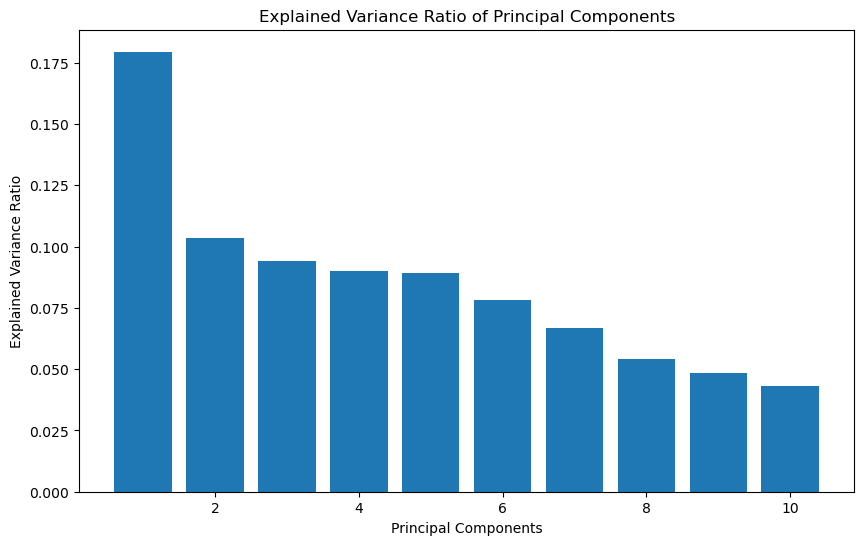

In [39]:
# Visualize explained variance ratio of principal components
plt.figure(figsize=(10, 6))
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()

In [ ]:
# Visualize data
# For example, you can create a correlation heatmap to see the relationships between variables
plt.figure(figsize=(12, 10))
sns.heatmap(weather_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()